In [1296]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Embedding, Concatenate, Activation, Dense, \
                                    Flatten, Dropout, Conv1D, Reshape, BatchNormalization,\
                                        GRU, Bidirectional,SpatialDropout1D, GaussianDropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import AUC
from tensorflow.keras.initializers import Constant, RandomUniform
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, LearningRateScheduler
import matplotlib.pyplot as plt
import os

import tensorflow.keras.backend as K

print('Tensorflow version = {}'.format(tf.__version__))
print(os.getcwd())
import pandas as pd
import numpy as np
from os import path
import sys
from scipy.linalg import toeplitz

rootdir = "/home/kostas/Datasets/"
print("current dir : {}".format(os.getcwd()))
print("rootdir : {}".format(rootdir) )

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"


Tensorflow version = 2.4.0-dev20200731
/home/kostas/Code/Marina/tdnn_skill_names_w2v
current dir : /home/kostas/Code/Marina/tdnn_skill_names_w2v
rootdir : /home/kostas/Datasets/


In [1297]:
USE_W2V = True
#USE_W2V = False 
#emb_size = 300
emb_size = 300
#w2v_emb_size = 300 
w2v_emb_size = 100
L = 50
max_epochs = 30
beta = 1e-3
#mod =  'tdnn_model' 
mod =  'bigru_model'
spatd = None
gausd = None
if mod == 'bigru_model':
    num_hidden = [50,25]
    batch_size = 32
    
elif mod == 'tdnn_model':
    num_hidden = [20,15,10,5]
    batch_size = 50
    
use_sigmoid = False
CREATE_NEW_DATA_SPLIT = True
global fold
    
#DATASET = 'Assistment2009_corrected'
DATASET = 'assist2009_updated'
#DATASET = 'fsaif1tof3'
#DATASET = 'Assistment2012_13'
#DATASET = 'Assistment2017'

max_v_auc = []

In [1298]:
# Function `printProgressBar`: function that prints progress bar in the console

# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '',
                      decimals = 1, length = 100, fill = '█', printEnd = ""):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd, flush=True)
    # Print New Line on Complete
    if iteration == total: 
        print()


In [1299]:
#Read file in 3-lines format and return `data` numpy array

def read_file_3lines(file, start_user):
    user_ids = []
    skill_ids = []
    correct = []
    with open(file, "r") as f:
        line = f.readline()
        cnt = 0
        user_id = start_user
        try:
            num_responses = int(line)
        except:
            print('Error')
        user_ids += [user_id]*num_responses
        while line:
            line = f.readline()
            if line=="":
                break
            cnt += 1
            if cnt%3 == 0:
                user_id += 1
                num_responses = int(line)
                user_ids += [user_id]*num_responses
            elif cnt%3 == 1:
                skill_ids += line.replace("\n","").split(",")
            elif cnt%3==2:
                correct += line.replace("\n","").split(",")
        user_ids = np.reshape(np.array(user_ids),[-1,1])
        num_unique_users = np.unique(user_ids[:,0]).shape[0]
        skill_ids = np.reshape(np.array(skill_ids).astype(int),[-1,1])
        correct = np.reshape(np.array(correct).astype(int),[-1,1])
        idx = np.reshape((correct==0) + (correct==1), [-1])
        data = np.hstack((user_ids[idx], skill_ids[idx], correct[idx]))
        return data, num_unique_users

In [1300]:
def gen_inputs_targets(data, user_ids, N, prefix):
    printProgressBar(0, N, prefix = prefix, suffix = 'Complete', length = 50)
    
    x = None
    t = None
    start = True
    for i,student_id in enumerate(user_ids):
        # Make an array with all the data for this student
        student_data = data[data[:,0]==student_id]
        skill_hist = toeplitz(student_data[:,1],0.0*np.ones([1,L]))
        responses_hist = toeplitz(student_data[:,2],0.0*np.ones([1,L]))
        student_data = np.hstack((skill_hist,
                                np.fliplr(responses_hist)
                                ))
        if start:
            start = False
            x = student_data[1:,0:2*L-1]
            t = student_data[1:,2*L-1].reshape([-1,1])
        else:
            x = np.vstack((x, student_data[1:,0:2*L-1]))
            t = np.vstack((t, student_data[1:,2*L-1].reshape([-1,1])))
        printProgressBar(i+1, N, prefix = prefix, suffix = 'Complete', length = 50)        
    return x, t

In [1301]:
'''
def read_data(DATASET = 'assist2009_updated', I=None):
    if (DATASET == 'assist2009_corrected') :
        train_file = path.join(rootdir,DATASET,"assistment_2009_corrected_train{}.csv".format(I))
        valid_file = path.join(rootdir,DATASET,"assistment_2009_corrected_valid{}.csv".format(I))
        test_file = path.join(rootdir,DATASET,"assistment_2009_corrected_test.csv")
        # Read embedding data
        emb_file = path.join(rootdir, DATASET,'skill_name_embeddings_corrected.csv') #300dim
        #emb_file = path.join(rootdir, DATASET,'Assistment_2009_corrected_skname_embeddings_FastText.csv')
        #emb_file = path.join(rootdir, DATASET, 'skill_name_embeddings_corrected_100d.csv')
        # Read skill names
        sknames_file = path.join(rootdir, DATASET,'skill_names_corrected.csv')
                
    elif DATASET == 'assist2009_updated':
        train_file = path.join(rootdir,DATASET,"assist2009_updated_train{}.csv".format(I))
        valid_file = path.join(rootdir,DATASET,"assist2009_updated_valid{}.csv".format(I))
        test_file = path.join(rootdir,DATASET,"assist2009_updated_test.csv")
        # Read embedding data
        #emb_file = path.join(rootdir, DATASET, 'skill_name_embeddings_updated300d.csv')
        #emb_file = path.join(rootdir, DATASET, 'Assist2009_updated_skname_embeddings_FastText.csv')
        emb_file = path.join(rootdir, DATASET, 'skill_name_embeddings_updated100d.csv')
        # Read skill names
        sknames_file = path.join(rootdir, DATASET,'skill_names_updated.csv')
        
    elif DATASET == 'fsaif1tof3': 
        train_file = path.join(rootdir,DATASET,"fsaif1tof3_train{}.csv".format(I))
        valid_file = path.join(rootdir,DATASET,"fsaif1tof3_valid{}.csv".format(I))
        test_file = path.join(rootdir,DATASET,"fsaif1tof3_test.csv")
        # Read embedding data
        emb_file = path.join(rootdir, DATASET,'fsaif1tof3_embeddings_300d.csv')
        #emb_file = path.join(rootdir, DATASET,'fsaif1tof3_embeddings_100d.csv')
        # Read skill names
        sknames_file = path.join(rootdir, DATASET,'skill_name_question_id.csv')
        
    elif DATASET == 'Assistment2012_13':
        train_file = path.join(rootdir,DATASET,"assistment2012_13_3lines_train{}_3lines.csv".format(I))
        valid_file = path.join(rootdir,DATASET,"assistment2012_13_3lines_valid{}_3lines.csv".format(I))
        test_file = path.join(rootdir,DATASET,"assistment2012_13_3lines_test.csv")
        # Read embedding data
        emb_file = path.join(rootdir, DATASET, 'skill_name_embeddings_12_13.csv') #w2v 300d
        #emb_file = path.join(rootdir, DATASET, 'Assistment2012_13_skname_embeddings_FastText.csv')
        #emb_file = path.join(rootdir, DATASET, 'skill_name_embeddings_updated100d.csv')
        # Read skill names
        sknames_file = path.join(rootdir, DATASET,'skill_names_12_13.csv')    
    elif DATASET == 'Assistment2017':
        train_file = path.join(rootdir,DATASET,"assistment2017_train{}.csv".format(I))
        valid_file = path.join(rootdir,DATASET,"assistment2017_valid{}.csv".format(I))
        test_file = path.join(rootdir,DATASET,"assistment2017_test.csv")
        # Read embedding data
        #emb_file = path.join(rootdir, DATASET, 'Assistment2017_skill_names_embeddings_300d.csv')
        emb_file = path.join(rootdir, DATASET, 'assistment20017_skname_embeddings_FastText.csv')
        #emb_file = path.join(rootdir, DATASET, 'Assistment2017_skill_names_embeddings_100d.csv')
        # Read skill names
        sknames_file = path.join(rootdir, DATASET,'skill_names_assistment2017.csv')    
        
    else :
        print ('Dataset file not found')
    
    skill_names = pd.read_csv(sknames_file, sep=',', header=None).values
    num_skills = skill_names.shape[0]     
    
    if USE_W2V:
        embeddings = pd.read_csv(emb_file, sep=',', header=None)# 
        # Add a zero row at the beginning
        embeddings = np.vstack((np.zeros([1,w2v_emb_size]), embeddings))   
    else:
        #embeddings = None
        embeddings = np.zeros([num_skills,emb_size])
        embeddings = np.vstack((np.zeros([1,emb_size]), embeddings))
                   
    start_user = 1
    data_train, N_train = read_file_3lines(train_file, start_user)
    start_user += N_train
    data_valid, N_valid = read_file_3lines(valid_file, start_user)
    start_user += N_valid
    data_test, N_test = read_file_3lines(test_file, start_user)
    return data_train, data_test, data_valid, embeddings, skill_names
'''

'\ndef read_data(DATASET = \'assist2009_updated\', I=None):\n    if (DATASET == \'assist2009_corrected\') :\n        train_file = path.join(rootdir,DATASET,"assistment_2009_corrected_train{}.csv".format(I))\n        valid_file = path.join(rootdir,DATASET,"assistment_2009_corrected_valid{}.csv".format(I))\n        test_file = path.join(rootdir,DATASET,"assistment_2009_corrected_test.csv")\n        # Read embedding data\n        emb_file = path.join(rootdir, DATASET,\'skill_name_embeddings_corrected.csv\') #300dim\n        #emb_file = path.join(rootdir, DATASET,\'Assistment_2009_corrected_skname_embeddings_FastText.csv\')\n        #emb_file = path.join(rootdir, DATASET, \'skill_name_embeddings_corrected_100d.csv\')\n        # Read skill names\n        sknames_file = path.join(rootdir, DATASET,\'skill_names_corrected.csv\')\n                \n    elif DATASET == \'assist2009_updated\':\n        train_file = path.join(rootdir,DATASET,"assist2009_updated_train{}.csv".format(I))\n        val

In [1302]:
def read_data_test(DATASET = 'Assistment2009_corrected'):
    if (DATASET == 'Assistment2009_corrected') :
        train_file = path.join(rootdir,DATASET,"assistment_2009_corrected_train.csv")
        test_file = path.join(rootdir,DATASET,"assistment_2009_corrected_test.csv")
        # Read embedding data
        #emb_file = path.join(rootdir, DATASET,'skill_name_embeddings_corrected.csv')
        emb_file = path.join(rootdir, DATASET,'Assistment_2009_corrected_skname_embeddings_FastText.csv')
        #emb_file = path.join(rootdir, DATASET, 'skill_name_embeddings_corrected_100d.csv')
        # Read skill names
        sknames_file = path.join(rootdir, DATASET,'skill_names_corrected.csv')
        skill_names = pd.read_csv(sknames_file, sep=',', header=None).values
        if mod == 'bigru_model':
            spatd = 0.2
            gausd = 0.2
        elif mod == 'tdnn_model':
            spatd = 0.5
            gausd = 0.6
               
    elif DATASET == 'assist2009_updated':
        train_file = path.join(rootdir,DATASET,"assist2009_updated_train.csv")
        test_file = path.join(rootdir,DATASET,"assist2009_updated_test.csv")
        # Read embedding data        
        #emb_file = path.join(rootdir, DATASET, 'skill_name_embeddings_updated300d.csv')
        #emb_file = path.join(rootdir, DATASET, 'Assist2009_updated_skname_embeddings_FastText.csv')
        emb_file = path.join(rootdir, DATASET, 'skill_name_embeddings_updated100d.csv')
        # Read skill names
        sknames_file = path.join(rootdir, DATASET,'skill_names_updated.csv')
        skill_names = pd.read_csv(sknames_file, sep=',', header=None).values
        if mod == 'bigru_model':
            spatd = 0.2
            gausd = 0.2
        elif mod == 'tdnn_model':
            spatd = 0.5
            gausd = 0.6
        
    elif DATASET == 'fsaif1tof3': 
        train_file = path.join(rootdir,DATASET,"fsaif1tof3_train.csv")
        test_file = path.join(rootdir,DATASET,"fsaif1tof3_test.csv")
        # Read embedding data
        emb_file = path.join(rootdir, DATASET,'fsaif1tof3_embeddings_300d.csv')
        #emb_file = path.join(rootdir, DATASET,'fsaif1tof3_skname_embeddings_FastText.csv')
        #emb_file = path.join(rootdir, DATASET,'fsaif1tof3_embeddings_100d.csv')
        # Read skill names
        sknames_file = path.join(rootdir, DATASET,'skill_name_question_id.csv')
        skill_names = pd.read_csv(sknames_file, header=None).values
        if mod == 'bigru_model':
            spatd = 0.5
            gausd = 0.9
        elif mod == 'tdnn_model':
            spatd = 0.5
            gausd = 0.9
        
        
    elif DATASET == 'Assistment2012_13':
        train_file = path.join(rootdir,DATASET,"assistment2012_13_train.csv")
        test_file = path.join(rootdir,DATASET,"assistment2012_13_test.csv")
        # Read embedding data
        #emb_file = path.join(rootdir, DATASET,'skill_name_embeddings_12_13.csv') #w2v 300d
        #emb_file = path.join(rootdir, DATASET,'Assistment2012_13_skname_embeddings_FastText.csv')
        #emb_file = path.join(rootdir, DATASET,'skill_name_embeddings_12_13_100d.csv')
        # Read skill names
        sknames_file = path.join(rootdir, DATASET,'skill_names_12_13.csv')
        skill_names = pd.read_csv(sknames_file, sep=',', header=None).values 
        if mod == 'bigru_model':
            spatd = 0.2
            gausd = 0.2
        elif mod == 'tdnn_model':
            spatd = 0.5
            gausd = 0.2
    
    elif DATASET == 'Assistment2017':
        train_file = path.join(rootdir,DATASET,"assistment2017_train.csv")
        test_file = path.join(rootdir,DATASET,"assistment2017_test.csv")
        # Read embedding data
        #emb_file = path.join(rootdir, DATASET, 'Assistment2017_skill_names_embeddings_300d.csv')
        #emb_file = path.join(rootdir, DATASET, 'assistment20017_skname_embeddings_FastText.csv')
        emb_file = path.join(rootdir, DATASET, 'Assistment2017_skill_names_embeddings_100d.csv')
        # Read skill names
        sknames_file = path.join(rootdir, DATASET,'skill_names_assistment2017.csv')
        skill_names = pd.read_csv(sknames_file, sep=',', header=None).values
        if mod == 'bigru_model':
            spatd = 0.2
            gausd = 0.2
        elif mod == 'tdnn_model':
            spatd = 0.5
            gausd = 0.4
    else :
        print ('Dataset file not found')
    
        
    num_skills = skill_names.shape[0]
    
    if USE_W2V:
        embeddings = pd.read_csv(emb_file, sep=',', header=None)#
        embeddings = np.vstack((np.zeros([1,w2v_emb_size]), embeddings))
    else:
        embeddings = np.zeros([num_skills,emb_size])
        embeddings = np.vstack((np.zeros([1,emb_size]), embeddings))
        
    # Add a zero row at the beginning
    #embeddings = np.vstack((np.zeros([1,w2v_emb_size]), embeddings))      
         
    start_user = 1
    data_train, N_train = read_file_3lines(train_file, start_user)
    start_user += N_train
    data_test, N_test = read_file_3lines(test_file, start_user)
    return data_train, data_test, embeddings, skill_names, spatd, gausd

In [1303]:
#%% Callback
global keys
global key_val_acc
global key_val_auc
global key_acc
global key_auc

def get_key(keystart, list):
    for k in list:
        if k[:len(keystart)] == keystart:
            return k
    return None

class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        global keys
        global key_val_acc
        global key_val_auc
        global key_acc
        global key_auc
        global filename
        if keys==[]:
            keys = list(logs.keys())
            key_val_acc = get_key('val_acc', keys)
            key_val_auc = get_key('val_auc', keys)
            key_acc = get_key('acc', keys)
            key_auc = get_key('auc', keys)
            filename = 'tdnn_w2v-f{:d}'.format(fold)\
                +'-e{epoch:02d}'\
                +'-val_loss{val_loss:.4f}-val_accuracy{val_accuracy:.4f}'\
                +'-val_auc{'+key_val_auc+':.4f}'\
                +'.h5'
            checkpoint.filepath = filename
        print("Starting training; got log keys: {}".format(keys))
        
        return

In [1304]:
def scheduler(epoch, beta):
    if epoch < 10:
        return beta
    else:
        return beta * tf.math.exp(0.1 * (10 - epoch))

callback1 = LearningRateScheduler(scheduler)

In [1305]:
def Average(lst): 
    return sum(lst) / len(lst) 

In [1306]:
# Bi-GRU model

def model_bigru(num_hidden = [10], use_sigmoid=False):
    num_hidden = num_hidden+[1]    # add the extra output layer
    num_layers = len(num_hidden)
    # Inputs
    q_ids = Input(shape=[L], dtype=tf.int32)
    hist = Input(shape=[L-1])
    
    if USE_W2V:
        print("!!!!!!!!!!!! Using Pre-trained Skil name Embeddings!!!!")
        initial_emb = Constant(embeddings/(L*w2v_emb_size))
        q = Embedding(embeddings.shape[0], w2v_emb_size,
                    embeddings_initializer=initial_emb,mask_zero=True)(q_ids)  #, trainable=False
        
        initial_h_emb = RandomUniform(
                        minval=-1/(w2v_emb_size*L), maxval=1/(w2v_emb_size*L))
        hist_emb = Embedding(2, w2v_emb_size,
                                   embeddings_initializer=initial_h_emb)(hist)
    else:
        print("!!!!!!!!!!!! Using Random Skil name Embeddings!!!!")
        initial_emb = RandomUniform(minval=-1/(emb_size*L),maxval=1/(emb_size*L))
        q = Embedding(embeddings.shape[0], emb_size,
                    embeddings_initializer=initial_emb)(q_ids)
        
        initial_h_emb = RandomUniform(
                        minval=-1/(emb_size*L), maxval=1/(emb_size*L))
        hist_emb = Embedding(2, emb_size,
                                   embeddings_initializer=initial_h_emb)(hist)
    
    
    print('q before conv:', q.shape)
    print('hist before conv:', hist.shape)
    
    q = tf.keras.layers.SpatialDropout1D(spatd)(q) 
    #q_conv = Conv1D(filters=100, kernel_size=3, strides=1, activation="relu")(q)
    q_conv = Conv1D(filters=100, kernel_size=3, strides=1)(q)
    #print('q after conv:', q_conv.shape)
    q_conv = BatchNormalization()(q_conv)    
    q_conv = Activation("relu")(q_conv)    
    #q_conv = Flatten()(q_conv)
    
    hist_emb = tf.keras.layers.SpatialDropout1D(spatd)(hist_emb)  
    #hist_conv = Conv1D(filters=100, kernel_size=3, strides=1, activation="relu")(hist_emb)
    hist_conv = Conv1D(filters=100, kernel_size=3, strides=1)(hist_emb)
    #print('hist after conv:', hist_conv.shape)
    hist_conv = BatchNormalization()(hist_conv)    
    hist_conv = Activation("relu")(hist_conv)   
    #hist_conv = Flatten()(hist_conv)
    
    #merged = Concatenate(axis=1)([q_conv, hist])
    x = Concatenate(axis=1)([q_conv, hist_conv])
    #print('merged ', merged.shape)      

    x = Bidirectional(GRU(units=64, return_sequences=False))(x)
    #print('lstm ', x_lstm.shape)
 
    x = GaussianDropout(gausd)(x)

    #x = Dropout(0.2)(x_lstm)
    
    for layer in range(num_layers):
        if layer == num_layers-1:
            activation = "sigmoid"            
        else:
            activation = "relu"                  
            x = Dense(num_hidden[layer], activation=activation)(x)     
    
    out = Dense(1, activation=activation)(x)
   
    model = Model(inputs=[q_ids, hist], outputs=out)
    
    return model


In [1307]:
#Time delay model
#TDNN Model

def model_tdnn(num_hidden = [10], use_sigmoid=False):
    num_hidden = num_hidden+[1]    # add the extra output layer
    num_layers = len(num_hidden)
    # Inputs
    q_ids = Input(shape=[L], dtype=tf.int32)
    hist = Input(shape=[L-1])
    
    if USE_W2V:
        print("!!!!!!!!!!!! Using Pre-trained Skil name Embeddings!!!!")
        initial_emb = Constant(embeddings/(L*w2v_emb_size))
        q = Embedding(embeddings.shape[0], w2v_emb_size,
                    embeddings_initializer=initial_emb,mask_zero=True)(q_ids)  #, trainable=False
        
        initial_h_emb = RandomUniform(
                        minval=-1/(w2v_emb_size*L), maxval=1/(w2v_emb_size*L))
        hist_emb = Embedding(2, w2v_emb_size,
                                   embeddings_initializer=initial_h_emb)(hist)
    else:
        print("!!!!!!!!!!!! Using Random Skil name Embeddings!!!!")
        initial_emb = RandomUniform(minval=-1/(emb_size*L),maxval=1/(emb_size*L))
        q = Embedding(embeddings.shape[0], emb_size,
                    embeddings_initializer=initial_emb)(q_ids)
        
        initial_h_emb = RandomUniform(
                        minval=-1/(emb_size*L), maxval=1/(emb_size*L))
        hist_emb = Embedding(2, emb_size,
                                   embeddings_initializer=initial_h_emb)(hist)
    
    
    q = tf.keras.layers.SpatialDropout1D(spatd)(q)
    q = Conv1D(50, 5)(q)
    q = BatchNormalization()(q)    
    q = Activation("relu")(q)    
    q = Flatten()(q)
        
    hist_emb = tf.keras.layers.SpatialDropout1D(spatd)(hist_emb)
    hist_emb = Conv1D(50,5)(hist_emb)
    hist_emb = BatchNormalization()(hist_emb)    
    hist_emb = Activation("relu")(hist_emb)   
    hist_emb = Flatten()(hist_emb)
    
    x = Concatenate(axis=1)([q, hist_emb])
    #x = Dense(20, activation="relu")(x) 
    x = tf.keras.layers.GaussianDropout(gausd)(x)    
   
    for layer in range(num_layers):
        if layer == num_layers-1:
            activation = "sigmoid"
            
        else:
            activation = "relu"                  
            x = Dense(num_hidden[layer], activation=activation)(x)           
   
    out = Dense(1, activation=activation)(x)
   
    model = Model(inputs=[q_ids, hist], outputs=out)
    
    return model



In [1308]:

# Main
'''
# Train-Validation
for fold in range(1,6):
    keys = []
    key_val_acc = None
    key_val_auc = None
    key_acc = None
    key_auc = None
    
    if USE_W2V:
        
        data_split_file = path.join(rootdir,DATASET,"{}_split_{}_w2v_3lines_L{}_emb_size={}.npz".format(DATASET,fold,L,w2v_emb_size))
    else:
        data_split_file = path.join(rootdir,DATASET,"{}_split_{}_not_w2v_3lines_L{}_emb_size={}.npz".format(DATASET,fold,L,emb_size))
        
    
    data_train, data_test,data_valid, embeddings, skill_names = read_data(DATASET=DATASET,I=fold)
    skill_ids = np.unique(np.hstack((
        data_train[:,1],
        data_valid[:,1],
        data_test[:,1]
    )))
    num_skills = len(skill_ids)
    train_user_ids = np.unique(data_train[:,0])
    valid_user_ids = np.unique(data_valid[:,0])
    test_user_ids = np.unique(data_test[:,0])
    N_train = len(train_user_ids)
    N_valid = len(valid_user_ids)
    N_test = len(test_user_ids)
    num_students = N_train + N_test + N_valid
    print('Fold {}'.format (fold))
    print('Number of skills: {}'.format(num_skills))
    print('Number of train students: {}'.format(N_train))
    print('Numberof validation students: {}'.format(N_valid))
    print('Number of test students: {}'.format(N_test))
    print('(total: {})'.format(num_students))

# ### Generate `x_train`, `x_test`, `t_train`, `t_test`  
# Every student `stud_id` has a sequence of responses `correct[0], correct[1],..., correct[T-1]` for some skill `skill_id`. The length `T` of the sequence depends on the student and the skill.   
# Every row of `x_train` or `x_test` contains the `student_id`, the `skill_id` and the response `correct[t]` for some time `t`. In addition to that it also includes the history of length `L` of previous responses `correct[t-1],..., correct[t-L]`. These responses *must* correspond to the same student and the same skill as time `t`. If history is shorter than `L` then the missing entries are filled with `0`.

    if not path.exists(data_split_file):
        
        #Generate Training, Validation and Testing data
        
        x_train, t_train = gen_inputs_targets(data_train,
                                train_user_ids, N_train, 'Train set:')
        x_valid, t_valid = gen_inputs_targets(data_valid,
                                valid_user_ids, N_valid, 'Validation set:')
        x_test, t_test = gen_inputs_targets(data_test,
                                test_user_ids, N_test, 'Test set:')
        
        np.savez(data_split_file,
                    embeddings = embeddings,
                    x_train = x_train,
                    x_valid = x_valid,
                    x_test = x_test,
                    t_train = t_train,
                    t_valid = t_valid,
                    t_test = t_test,
                    train_user_ids = train_user_ids,
                    valid_user_ids = valid_user_ids,
                    test_user_ids = test_user_ids,
                    N_train = N_train,
                    N_valid = N_valid,
                    N_test = N_test,
                    num_skills = num_skills,
                    num_students = num_students)    
    else:
        data_split = np.load(data_split_file)
        embeddings = data_split['embeddings']
        x_train = data_split['x_train']
        x_test = data_split['x_test']
        x_valid = data_split['x_valid']
        t_train = data_split['t_train']
        t_test = data_split['t_test']
        t_valid = data_split['t_valid']
        train_user_ids = data_split['train_user_ids']
        valid_user_ids = data_split['valid_user_ids']
        test_user_ids = data_split['test_user_ids']
        N_train = data_split['N_train']
        N_test = data_split['N_test']
        N_valid = data_split['N_valid']
        num_skills = data_split['num_skills']
        num_students = data_split['num_students']
 
    #Train the model
    acc_valid_base = np.sum(t_valid==1)/t_valid.shape[0]
    print('Baseline valid accuracy = {}'.format(acc_valid_base))   
    print("==================================================")
    print('L = {}, emb_size = {}, hidden={}'.format(L, emb_size, num_hidden))
    
    try:        
        del model 
        K.clear_session()
    except:
        print("no model to delete")
    
    if mod == 'w2v_model':    
        model = model_tdnn_w2v(num_hidden=num_hidden, use_sigmoid=use_sigmoid)
    elif mod == 'conv_model':    
        model = model_tdnn_conv(filters=num_filters, use_sigmoid=use_sigmoid)
    
    model.summary() 
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
                        filepath=None)
    my_callbacks = [
        MyCallback(),
        
        checkpoint
       
    ]
    
    model.compile(optimizer=Adamax(learning_rate=beta),
                loss= 'binary_crossentropy', #MeanSquaredError(), #,
                metrics=['accuracy', AUC()])
   
    history = model.fit([x_train[:,:L].astype(int), x_train[:,L:]], t_train,
                        validation_data=([x_valid[:,:L].astype(int), x_valid[:,L:]],t_valid),
                        epochs = max_epochs,
                        batch_size=batch_size,
                        verbose=1)#,
                        #callbacks=my_callbacks) #[ReduceLROnPlateau()]) #, , MyCallback()])

    keys = history.history.keys()
    key_val_acc = get_key('val_acc', keys)
    key_val_auc = get_key('val_auc', keys)
    key_acc = get_key('acc', keys)
    key_auc = get_key('auc', keys)    
    
    plt.figure(figsize=(9,6))
    ep = np.arange(1,max_epochs+1)
    plt.plot(ep, history.history[key_val_auc], 'r')
    plt.xticks(np.arange(0,max_epochs+1,5, dtype=np.int))
    plt.plot(ep, history.history[key_auc], 'b')
    plt.plot(ep, history.history[key_val_acc], 'r:')
    plt.plot(ep, history.history[key_acc], 'b:')
    plt.legend(['val.auc', 'auc', 'val.acc', 'acc'])
    plt.grid(b=True)
    if USE_W2V:
        title="DATASET={},split={},L={}, embsize={}, w2v={}, layers={}".format(
                DATASET, fold, L, w2v_emb_size, True, num_hidden)
    else:
        title="DATASET={},split={}, L={}, embsize={}, w2v={}, layers={}".format(
                DATASET, fold, L, emb_size, False, num_hidden)
    plt.title(title)
    plt.show()
    all_val_auc = np.array(history.history[key_val_auc])
    max_v_auc.append(max(all_val_auc))

if USE_W2V:
    model_title="{}_L={}_embsize={}_w2v={}_use_sigmoid={}_layers={}.png".format(
        DATASET, L, w2v_emb_size, True, use_sigmoid, num_hidden)
else:
    model_title="{}_L={}_embsize={}_w2v={}_use_sigmoid={}_layers={}.png".format(
        DATASET, L, emb_size, False, use_sigmoid, num_hidden)

model_file = path.join(rootdir,DATASET,model_title)

tf.keras.utils.plot_model(model, to_file=model_file, show_shapes=True)


#VALIDATION RESULT
av_val_auc = Average(max_v_auc)
print('Average validation auc of 5 folds cross-validation is {} '.format(av_val_auc))
'''

'\n# Train-Validation\nfor fold in range(1,6):\n    keys = []\n    key_val_acc = None\n    key_val_auc = None\n    key_acc = None\n    key_auc = None\n    \n    if USE_W2V:\n        \n        data_split_file = path.join(rootdir,DATASET,"{}_split_{}_w2v_3lines_L{}_emb_size={}.npz".format(DATASET,fold,L,w2v_emb_size))\n    else:\n        data_split_file = path.join(rootdir,DATASET,"{}_split_{}_not_w2v_3lines_L{}_emb_size={}.npz".format(DATASET,fold,L,emb_size))\n        \n    \n    data_train, data_test,data_valid, embeddings, skill_names = read_data(DATASET=DATASET,I=fold)\n    skill_ids = np.unique(np.hstack((\n        data_train[:,1],\n        data_valid[:,1],\n        data_test[:,1]\n    )))\n    num_skills = len(skill_ids)\n    train_user_ids = np.unique(data_train[:,0])\n    valid_user_ids = np.unique(data_valid[:,0])\n    test_user_ids = np.unique(data_test[:,0])\n    N_train = len(train_user_ids)\n    N_valid = len(valid_user_ids)\n    N_test = len(test_user_ids)\n    num_student

In [1309]:
### Train Test
#Train - test
for count in range (1,2):
    print(" ===============EXPERIMENT NUMBER  {}============".format(count))
    print("~~~~~~~~~~~~~~~DATASET {} ~~~~~~~~~~~".format(DATASET))
    max_test_auc = []
    
    if USE_W2V:
        data_file = path.join(rootdir,DATASET,"{}_w2v_3lines_L{}_emb_size={}.npz".format(DATASET,L,w2v_emb_size))
    else:
        data_file = path.join(rootdir,DATASET,"{}_no_w2v_3lines_L{}_emb_size={}.npz".format(DATASET,L,emb_size))
        
        
    data_train, data_test, embeddings, skill_names, spatd, gausd = read_data_test(DATASET=DATASET)
    skill_ids = np.unique(np.hstack((
        data_train[:,1],
        data_test[:,1]
    )))
    num_skills = len(skill_ids)
    train_user_ids = np.unique(data_train[:,0])
    test_user_ids = np.unique(data_test[:,0])
    N_train = len(train_user_ids)
    N_test = len(test_user_ids)
    num_students = N_train + N_test
    
    print('Number of skills: {}'.format(num_skills))
    print('Number of train students: {}'.format(N_train))
    print('Number of test students: {}'.format(N_test))
    print('(total: {})'.format(num_students))
    
    # ### Generate `x_train`, `x_test`, `t_train`, `t_test`  
    # Every student `stud_id` has a sequence of responses `correct[0], correct[1],..., correct[T-1]` for some skill `skill_id`. The length `T` of the sequence depends on the student and the skill.   
    # Every row of `x_train` or `x_test` contains the `student_id`, the `skill_id` and the response `correct[t]` for some time `t`. In addition to that it also includes the history of length `L` of previous responses `correct[t-1],..., correct[t-L]`. These responses *must* correspond to the same student and the same skill as time `t`. If history is shorter than `L` then the missing entries are filled with `0`.
    
    if not path.exists(data_file):
        
        #Generate Training, Validation and Testing data
        
        x_train, t_train = gen_inputs_targets(data_train,
                                train_user_ids, N_train, 'Train set:')
        x_test, t_test = gen_inputs_targets(data_test,
                                test_user_ids, N_test, 'Test set:')
        
        np.savez(data_file,
                    embeddings = embeddings,
                    x_train = x_train,
                    x_test = x_test,
                    t_train = t_train,
                    t_test = t_test,
                    train_user_ids = train_user_ids,
                    test_user_ids = test_user_ids,
                    N_train = N_train,
                    N_test = N_test,
                    num_skills = num_skills,
                    num_students = num_students)    
    else:
        data_split = np.load(data_file)
        embeddings = data_split['embeddings']
        x_train = data_split['x_train']
        x_test = data_split['x_test']
        t_train = data_split['t_train']
        t_test = data_split['t_test']
        train_user_ids = data_split['train_user_ids']
        test_user_ids = data_split['test_user_ids']
        N_train = data_split['N_train']
        N_test = data_split['N_test']
        num_skills = data_split['num_skills']
        num_students = data_split['num_students']
     
    #Train the model
    acc_test_base = np.sum(t_test==1)/t_test.shape[0]
    print('Baseline test accuracy = {}'.format(acc_test_base))   
    print("==================================================")
    if USE_W2V:
        print('L = {}, emb_size = {}, hidden={}, spatial dropout = {}, gaussian dropout = {}'.format(
                L, w2v_emb_size, num_hidden, spatd, gausd))
    else:
        print('L = {}, emb_size = {}, hidden={}, spatial dropout = {}, gaussian dropout = {}'.format(
                L, emb_size, num_hidden, spatd, gausd))
    
    try:        
        del model 
        K.clear_session()
    except:
        print("no model to delete")
    
    if mod == 'tdnn_model':    
        print("~~~~~~~Train TDNN MODEL~~~~~~~~~~")
        model = model_tdnn(num_hidden=num_hidden, use_sigmoid=use_sigmoid)    
       
        model.summary()   
        model.compile(optimizer=Adamax(learning_rate=beta),
                loss='binary_crossentropy',#MeanSquaredError(),# #
                metrics=['accuracy', AUC()])
    
        history = model.fit([x_train[:,:L].astype(int), x_train[:,L:]], t_train,
                           validation_data=([x_test[:,:L].astype(int), x_test[:,L:]],t_test),
                           epochs = max_epochs,
                           batch_size=batch_size,
                           verbose=1,
                           #callbacks=my_callbacks ) #[ReduceLROnPlateau()]) #, ), # MyCallback()])
                       )
    
    
    elif mod == 'bigru_model':    
        print("~~~~~~~~~~Train Bi-GRU MODEL~~~~~~~~")
        model = model_bigru(num_hidden=num_hidden, use_sigmoid=use_sigmoid)   
  
        model.summary()
        model.compile(optimizer=Adam(learning_rate=beta),
            loss= 'binary_crossentropy',
            metrics=['accuracy', AUC()])
         
        history = model.fit([x_train[:,:L].astype(int), x_train[:,L:]], t_train,
                           validation_data=([x_test[:,:L].astype(int), x_test[:,L:]],t_test),
                           epochs = max_epochs,
                           batch_size=batch_size,
                           verbose=1,
                           callbacks=callback1
                       )
    
    
    #plot the model
    if USE_W2V:
        model_title="{}_L={}_embsize={}_w2v={}_layers={}.png".format(
                DATASET, L, w2v_emb_size, True, num_hidden)
    else:
        model_title="{}_L={}_embsize={}_w2v={}_layers={}.png".format(
                DATASET, L, emb_size, False, num_hidden)
        
    model_file = path.join(rootdir,DATASET,model_title)
    tf.keras.utils.plot_model(model, to_file=model_file, show_shapes=True)    
        
    keys = history.history.keys()
    key_val_acc = get_key('val_acc', keys)
    key_val_auc = get_key('val_auc', keys)
    key_acc = get_key('acc', keys)
    key_auc = get_key('auc', keys)
    
        
    print("!!!!!!!!!!!!!!!!! TEST RESULTS !!!!!!!!!!!!!!!!!!!!!")
    all_test_auc = np.array(history.history[key_val_auc])
    max_test_auc.append(max(all_test_auc))
    av_test_auc = Average(all_test_auc)
    
    print(" =============== RESULTS OF EXPERIMENT NUMBER  {} ============".format(count))
    print('Max test auc  is {} '.format(max(all_test_auc)))
    print('Average test auc  is {} '.format(av_test_auc))

 ===============EXPERIMENT NUMBER  1============
~~~~~~~~~~~~~~~DATASET assist2009_updated ~~~~~~~~~~~
Number of skills: 110
Number of train students: 2921
Number of test students: 1230
(total: 4151)
Baseline test accuracy = 0.6602920480292248
L = 50, emb_size = 100, hidden=[50, 25], spatial dropout = 0.2, gaussian dropout = 0.2
~~~~~~~~~~Train Bi-GRU MODEL~~~~~~~~
!!!!!!!!!!!! Using Pre-trained Skil name Embeddings!!!!
q before conv: (None, 50, 100)
hist before conv: (None, 49)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 49)]         0                                            

In [1310]:
print("~~~~~EVALUATION RESULTS ~~~~~~~")
model.evaluate([x_test[:,:L].astype(int), x_test[:,L:].astype(int)],
                            t_test,
                       batch_size=batch_size,
                       verbose=1)

~~~~~EVALUATION RESULTS ~~~~~~~
3131/3131 [==============================] - 24s 8ms/step - loss: 0.4568 - accuracy: 0.7751 - auc: 0.8252


[0.4567911922931671, 0.7750751376152039, 0.825153112411499]

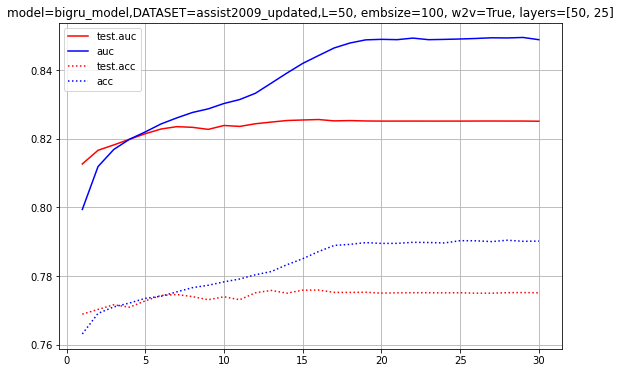

In [1311]:
plt.figure(figsize=(9,6))
ep = np.arange(1,max_epochs+1)
plt.plot(ep, history.history[key_val_auc], 'r')
plt.xticks(np.arange(0,max_epochs+1,5, dtype=np.int))
plt.plot(ep, history.history[key_auc], 'b')
plt.plot(ep, history.history[key_val_acc], 'r:')
plt.plot(ep, history.history[key_acc], 'b:')
plt.legend(['test.auc', 'auc', 'test.acc', 'acc'])
plt.grid(b=True)
if USE_W2V:
    title="model={},DATASET={},L={}, embsize={}, w2v={}, layers={}".format(
                mod, DATASET, L, w2v_emb_size, True, num_hidden)
else:
    title="model={},DATASET={}, L={}, embsize={}, w2v={}, layers={}".format(
            mod, DATASET, L, emb_size, False, num_hidden)
plt.title(title)
plt.show()